In [4]:
from ansys.dpf import core as dpf

2nd step : create a model

In [5]:
path =  r'c:\temp\cadfem.rst'
model = dpf.Model(path)

In [6]:
print(model.metadata.time_freq_support)

Time/Frequency Info:
	Number of sets: 2

With complex values
 
 Cumulative      Time (s)       Loadstep     Substep   
     1             1.0             1            1      
     2             2.0             2            1      



In [7]:
mesh = model.metadata.meshed_region

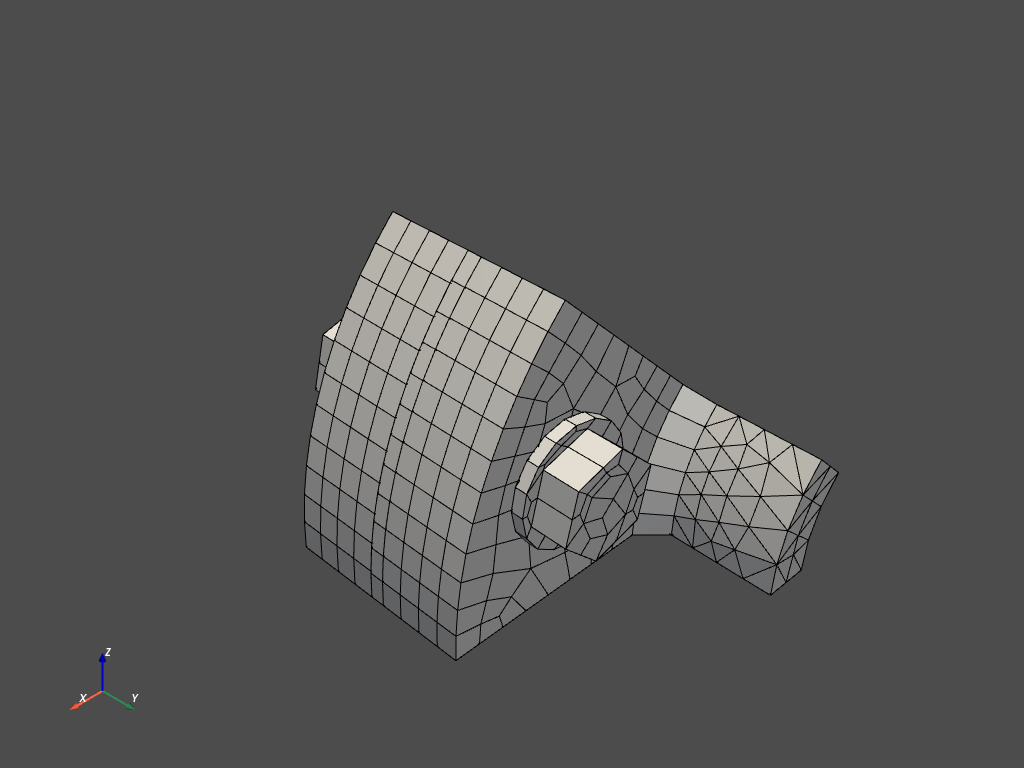

[(192.2462683908629, 142.2120872308629, 171.393755765849),
 (50.03418116, 0.0, 29.181668534986102),
 (0.0, 0.0, 1.0)]

In [8]:
mesh.plot()

In [9]:
timeScoping = dpf.Scoping()
timeScoping.ids = [2]

## compute averaged contact pressure
##### 1. read elemental nodal contact pressure on a given named selection
##### 2. average the elemental nodal pressure into elemental pressure
##### 3. read elements areas on the same surface
##### 4. multiply element area per element pressure to get a force on each element
##### 5. accumulate all element forces
##### 6. accumulate all element areas
##### 7. divide the accumelated force per the accumulated area to get the averaged pressure

In [10]:
scoping_provider = model.operator("scoping_provider_by_ns")
scoping_provider.inputs.named_selection_name.connect("DICHTUNG_FL_1")
scoping_provider.inputs.requested_location.connect(dpf.locations.elemental)

area = model.operator("mapdl::nmisc")
area.inputs.mesh_scoping.connect(scoping_provider.outputs.mesh_scoping)
area.inputs.time_scoping.connect(timeScoping)
area.connect(10,58)

ElePressure = model.operator("ECT_PRES")
ElePressure.inputs.time_scoping.connect(timeScoping)
ElePressure.inputs.mesh_scoping.connect(scoping_provider.outputs.mesh_scoping)

avg = dpf.Operator("entity_average")
avg.connect(0,ElePressure,0)

dot = area*avg

accu_force = dpf.Operator("accumulate")
accu_force.inputs.connect(dot.outputs)

accu_area = dpf.Operator("accumulate")
accu_area.inputs.connect(area.outputs)

div = accu_force / accu_area

In [11]:
res = model.results

In [12]:
disp = res.displacement()

In [13]:
fields = disp.outputs.fields_container()

In [14]:
fields[0].unit

'mm'

In [15]:
field = avg.outputs.field()

In [16]:
field.unit

'MPa'

In [17]:
field = dot.outputs.field()

In [18]:
field.unit

'N'

In [19]:
field = div.outputs.field()


In [20]:
field.data

array([4.0482138])

In [21]:
field.unit

'MPa'

##### create a sub mesh correspending to the named selection

In [22]:
field = dot.outputs.field()

In [23]:
field.scoping.location = "Elemental"

In [24]:
subMeshProvider = dpf.Operator("mesh::by_scoping")

In [25]:
subMeshProvider.inputs.mesh.connect(mesh)
subMeshProvider.inputs.scoping.connect(field.scoping)

In [26]:
subMesh = subMeshProvider.outputs.mesh()

In [27]:
subMesh.elements.n_elements

75

In [28]:
field.scoping.size

75

In [ ]:
subMesh.plot(field, notebook = False)

ERROR:root:1: #version 150


In [ ]:
subMesh.elements.element_types_field.data